In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import matplotlib as mpl
import os
from matplotlib.lines import Line2D
from collections import Counter
import math
from sklearn.decomposition import PCA
from aging.behavior.syllables import relabel_by_usage
from tqdm import tqdm
%matplotlib inline
import warnings
warnings.simplefilter('ignore')
import random
import scipy

In [4]:
# plot/colors definitions
cpath = '/n/groups/datta/win/longtogeny/code/notebooks/exploration/Dana'
data_loc=cpath+'/figs/'
try:
    os.mkdir(data_loc)
except FileExistsError:
    # directory already exists
    pass

plt.style.use('seaborn-paper')

In [5]:
def KLD_analysis(frequencies):
    '''rows are sessions (or mice/phases), columns are variables (syllables)'''
    cohort_dist=np.zeros((len(frequencies),len(frequencies)),dtype=float)
    x=0
    y=0
    for i in frequencies:
        for j in frequencies:
            i[i==0]=.0000000001
            j[j==0]=.0000000001
            cohort_dist[x,y]=scipy.stats.entropy(pk=np.array(i), qk=np.array(j))
            y=y+1
        y=0
        x=x+1
    cohort_dist[cohort_dist == 0] = 'nan'
    return cohort_dist

def plot_KLD(cohort_dist,age_labels,name,vmax=1):
    # cohort_dist is matrix of
    seqmatcolor='Purples_r'
    cmg=sns.clustermap(cohort_dist,cmap=seqmatcolor,xticklabels=1,yticklabels=1,
                   colors_ratio=0.2,cbar_pos=(0.99, 0.045, 0.03, .70),
                   col_cluster=False,row_cluster=False,
                   method='average',metric='sqeuclidean', vmax=vmax)
    cmg.fig.set_size_inches(10,10)
    ax = cmg.ax_heatmap
    ax.set_xticklabels(age_labels)
    ax.set_yticklabels(age_labels)
    ax.set_title('Syllable Usage based KLD distance',fontsize=20)
    plt.show()

In [6]:
## upload data frame females
path = Path('/n/groups/datta/win/longtogeny/data/ontogeny/version_04/longtogeny_males_clean.parquet')
mdf = pd.read_parquet(path)

In [33]:
## stability kld and euclidian
from sklearn.metrics import pairwise_distances
newdf=mdf.copy()
# get rid of CRL mice
newdf = newdf[newdf.index.get_level_values(0)<800]

In [56]:
# for males point by point kld and euc distance
n=0
ages=[]
kld=[]
euc=[]
mouse=[]
dif=[]
for age,_df in enumerate(newdf.groupby('mouse')):
    ages.extend(_df[1].index.get_level_values(0).to_numpy()[:-1])
    tmp = pd.Series(_df[1].index.get_level_values(0)).diff().to_numpy()
    dif.extend(tmp)
    mouse.extend(_df[1].index.get_level_values(1).to_numpy()[:-1])
    data_temp = _df[1].to_numpy()
    kld_temp = KLD_analysis(data_temp)
    utemp = pairwise_distances(data_temp)
    kld.append(np.diagonal(kld_temp,offset=1).copy()/ tmp[1:])
    euc.append(np.diagonal(utemp,offset=1).copy() / tmp[1:])

<Axes: >

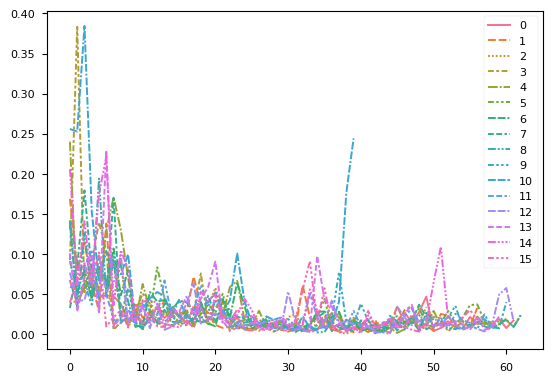

In [57]:
sns.lineplot(kld, estimator='mean', errorbar='se')

In [58]:
flat_kld = [item for sublist in kld for item in sublist]
flat_euc = [item for sublist in euc for item in sublist]

In [59]:
df = pd.DataFrame()
df['kld']=flat_kld
df['age'] = ages
df['euc'] = flat_euc
df['mouse'] = mouse

In [60]:
'''
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
df
'''

"\npd.set_option('display.max_rows', None)\npd.set_option('display.max_columns', None)\ndf\n"

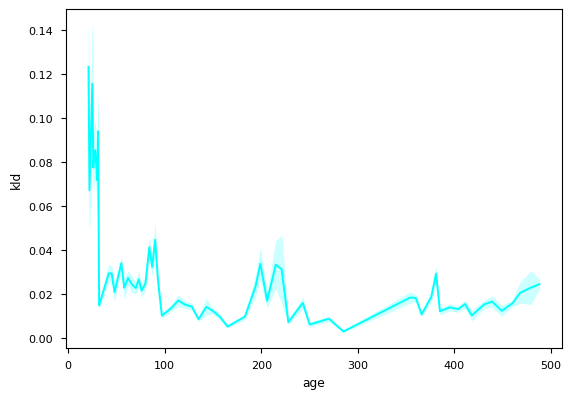

In [61]:
g= sns.lineplot(data=df, x='age', y='kld', estimator='mean', errorbar='se',c='cyan')
#g.set_xticks(range(len(np.unique(ages)))) # <--- set the ticks first
#g.set_xticklabels(np.unique(ages))

In [62]:
# smooth the data

In [63]:
from scipy.ndimage.filters import gaussian_filter1d

In [64]:
# prepare data
data=df.copy()
ind = data['age'].unique()
concat = pd.DataFrame()
for m, _df in data.groupby('mouse'):
    #_df=_df.drop_duplicates(subset=['ages'])
    temp= gaussian_filter1d(_df['kld'], sigma=2)
    _df['kld'] = temp
    concat=pd.concat([concat,_df])

In [65]:
#concat = concat[concat.age>30]

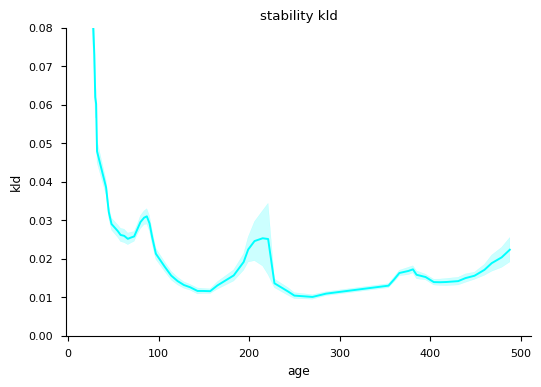

In [66]:
fig, ax = plt.subplots()
fig.set_size_inches(6,4)
sns.lineplot(data=concat, x="age", y="kld", estimator='mean', errorbar='se',c='cyan')
ax.set_title('stability kld')
ax.set_ylim(0,0.08)
sns.despine()
em = df.copy()
#plt.savefig(data_loc +'long_stability.pdf', bbox_inches='tight')

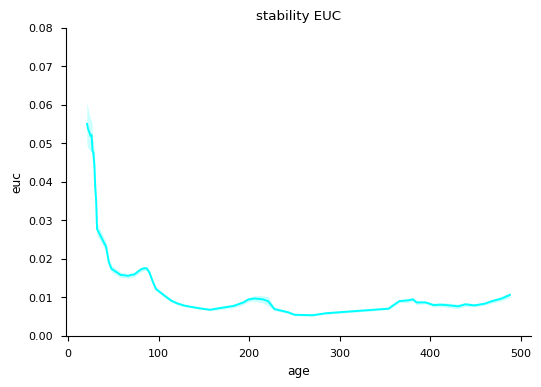

In [70]:
# prepare data euclidian
data=df.copy()
ind = data['age'].unique()
concat = pd.DataFrame()
for m, _df in data.groupby('mouse'):
    #_df=_df.drop_duplicates(subset=['ages'])
    temp= gaussian_filter1d(_df['euc'], sigma=2)
    _df['euc'] = temp
    concat=pd.concat([concat,_df])


fig, ax = plt.subplots()
fig.set_size_inches(6,4)
sns.lineplot(data=concat, x="age", y="euc", estimator='mean', errorbar='se',c='cyan')
ax.set_title('stability EUC')
ax.set_ylim(0,0.08)
sns.despine()
em = df.copy()
#plt.savefig(data_loc +'long_stability.pdf', bbox_inches='tight')

In [22]:
# for males 5 point window

In [23]:
df=newdf.groupby(['mouse','age']).mean()

In [24]:
xmale = pd.DataFrame()
kld=[]
euc=[]
age=[]
mouse=[]
n=5
for m,_df in enumerate(df.groupby('mouse')):
    kld1=[]
    euc1=[]
    age1=[]
    a=0
    b=False
    while True:
        data_temp = _df[1][a:a+n]
        if data_temp.empty:
            break
        #age1.append(np.floor(np.mean(data_temp.index.get_level_values(1))).astype(int))
        age1.append(data_temp.index.get_level_values(1)[0].astype(int))
        temp = data_temp.to_numpy()
        kld_temp = KLD_analysis(temp)
        utemp = pairwise_distances(temp)
        kld1.append(np.nanmean(kld_temp))
        euc1.append(np.nanmean(utemp))
        mouse.append(_df[0])
        len(age1)
        len(kld1)
        len(euc1)
        len(tmp)
        a=a+1
    #tmp = pd.Series(_df[1].index.get_level_values(1)).diff().to_numpy()
    tmp = pd.Series(age1).diff().to_numpy()
    kld.append(kld1/ tmp)
    #age.append(age1)
    age.append(age1)
    euc.append(euc1/ tmp)

<Axes: >

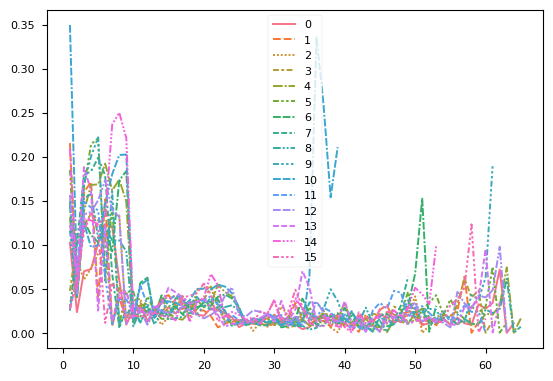

In [25]:
sns.lineplot(kld, estimator='mean', errorbar='se')

In [26]:
flat_kld = [item for sublist in kld for item in sublist]
flat_euc = [item for sublist in euc for item in sublist]
flat_age = [item for sublist in age for item in sublist]

In [27]:
df = pd.DataFrame()
df['kld']=flat_kld
df['age'] = flat_age
df['euc'] = flat_euc
df['mouse'] = mouse

<Axes: xlabel='age', ylabel='kld'>

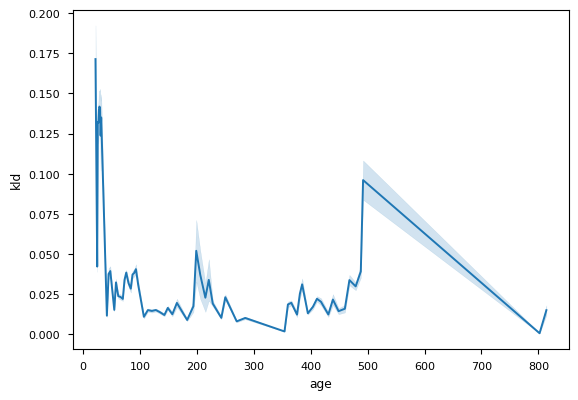

In [28]:
sns.lineplot(data=df, x='age', y='kld', estimator='mean', errorbar='se')

In [29]:
## smooth kld

In [30]:
from scipy.ndimage.filters import gaussian_filter1d

In [31]:
# prepare data
data=df.copy()
ind = data['age'].unique()
concat = pd.DataFrame()
for m, _df in data.groupby('mouse'):
    #_df=_df.drop_duplicates(subset=['ages'])
    temp= gaussian_filter1d(_df['kld'], sigma=5)
    _df['kld'] = temp
    concat=pd.concat([concat,_df])

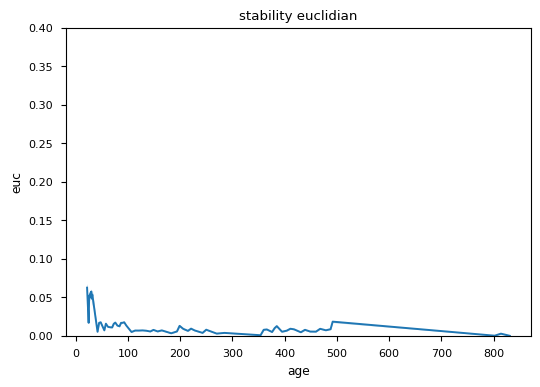

In [32]:
fig, ax = plt.subplots()
fig.set_size_inches(6,4)
sns.lineplot(data=concat, x="age", y="euc", estimator='mean', errorbar='se')
ax.set_title('stability euclidian')
ax.set_ylim(0,0.4)
em = df.copy()